In [342]:
!pip install statsmodels==0.12.2

In [343]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.base.transform import BoxCox
from scipy.special import inv_boxcox
from statsmodels.tsa.stattools import kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning

import warnings
warnings.filterwarnings('ignore', category=InterpolationWarning)

In [344]:
aus_retail = pd.read_csv('https://raw.githubusercontent.com/vpozdnyakov/probabilistic_forecasting/main/datasets/aus_retail.csv',  index_col=0)
aus_retail.index = pd.to_datetime(aus_retail.index)

### Min max scaler

In [386]:
train_bound = pd.Timestamp('2016-02-01')
train = aus_retail[aus_retail.index <= train_bound].iloc[:, :4]
test = aus_retail[aus_retail.index > train_bound].iloc[:, :4]
train.shape, test.shape

((407, 4), (60, 4))

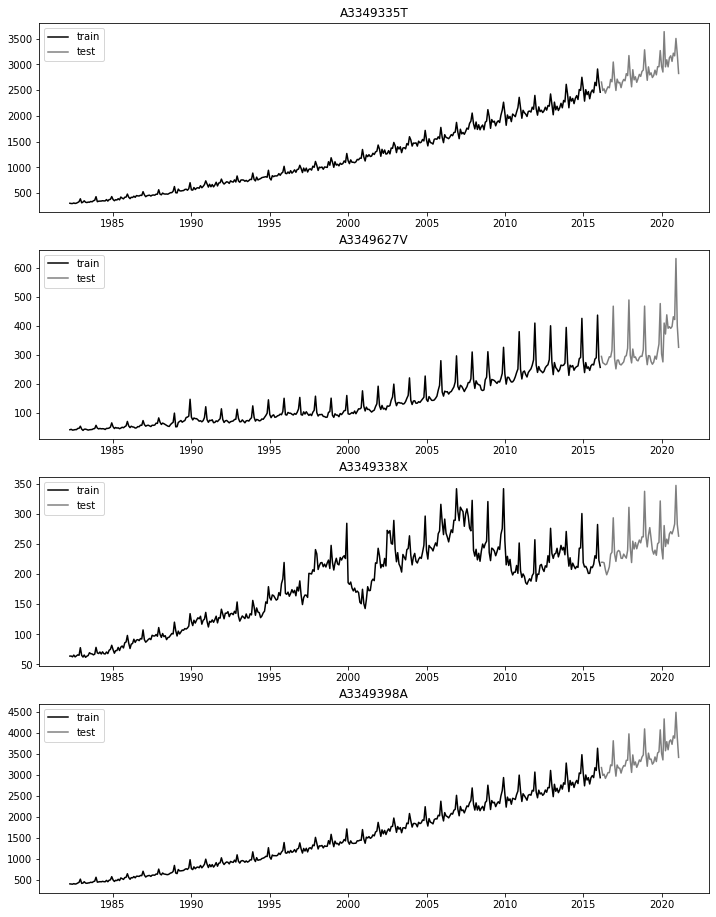

In [387]:
plt.figure(figsize=(12, 4*4))
for i, col in enumerate(train.columns):
    plt.subplot(4, 1, i+1)
    plt.plot(train[col], c='black', label='train')
    plt.plot(test[col], c='black', label='test', alpha=0.5)
    plt.legend()
    plt.title(col)

In [388]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler((1, 2))
scaler.fit(train.values)
values = scaler.transform(train.values)
for i, col in enumerate(train.columns):
    train[col] = values[:, i]
train.head()

,A3349335T,A3349627V,A3349338X,A3349398A
Series ID,,,,
1982-04-01,1.002028,1.006035,1.007140,1.002385
1982-05-01,1.000000,1.009555,1.007497,1.001208
1982-06-01,1.000077,1.002514,1.002856,1.000000
1982-07-01,1.003866,1.004023,1.013210,1.004150
1982-08-01,1.000536,1.007040,1.002499,1.000867


In [389]:
import requests
url = 'https://raw.githubusercontent.com/vpozdnyakov/probabilistic_forecasting/main/models/TCN.py'
open('TCN.py', 'wb').write(requests.get(url).content);

In [390]:
from TCN import TCNModule
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.optim import Adam

from IPython.display import clear_output

In [391]:
class DeepTCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.tcn = TCNModule(
            input_size=4, input_chunk_length=120, 
            kernel_size=2, num_filters=16, 
            num_layers=4, dilation_base=2, 
            weight_norm=True, target_size=8, 
            target_length=120, dropout=0.2)
    
    def forward(self, x):
        h = self.tcn(x)
        mu = h[..., ::2]
        sigma = F.softplus(h[..., 1::2])
        return mu, sigma

In [392]:
model = DeepTCN()
noise = torch.randn(256, 120, 4)
mu, sigma = model(noise)
mu.shape, sigma.shape

(torch.Size([256, 120, 4]), torch.Size([256, 120, 4]))

In [393]:
def gaussian_loss(mu, sigma, y, softZero=1e-4):
    logGaussian = -torch.log(2*np.pi*(sigma**2)+softZero)/2-(y-mu)**2/(2*(sigma**2)+softZero)
    res = -logGaussian.sum(dim=0)
    return res.mean()

In [394]:
train_torch = []
for i in range(train.shape[0] - 180 + 1):
    train_torch.append(train.iloc[i:i+180].values)
train_torch = torch.Tensor(train_torch).to('cuda')
train_torch.shape

torch.Size([228, 180, 4])

In [395]:
model = DeepTCN()
model.to('cuda')

DeepTCN(
  (tcn): TCNModule(
    (dropout): Dropout(p=0.2, inplace=False)
    (res_blocks): ModuleList(
      (0): ResidualBlock(
        (dropout_fn): Dropout(p=0.2, inplace=False)
        (conv1): Conv1d(4, 16, kernel_size=(2,), stride=(1,))
        (conv2): Conv1d(16, 16, kernel_size=(2,), stride=(1,))
        (conv3): Conv1d(4, 16, kernel_size=(1,), stride=(1,))
      )
      (1): ResidualBlock(
        (dropout_fn): Dropout(p=0.2, inplace=False)
        (conv1): Conv1d(16, 16, kernel_size=(2,), stride=(1,), dilation=(2,))
        (conv2): Conv1d(16, 16, kernel_size=(2,), stride=(1,), dilation=(2,))
      )
      (2): ResidualBlock(
        (dropout_fn): Dropout(p=0.2, inplace=False)
        (conv1): Conv1d(16, 16, kernel_size=(2,), stride=(1,), dilation=(4,))
        (conv2): Conv1d(16, 16, kernel_size=(2,), stride=(1,), dilation=(4,))
      )
      (3): ResidualBlock(
        (dropout_fn): Dropout(p=0.2, inplace=False)
        (conv1): Conv1d(16, 16, kernel_size=(2,), stride=(1,)

In [396]:
logs = []

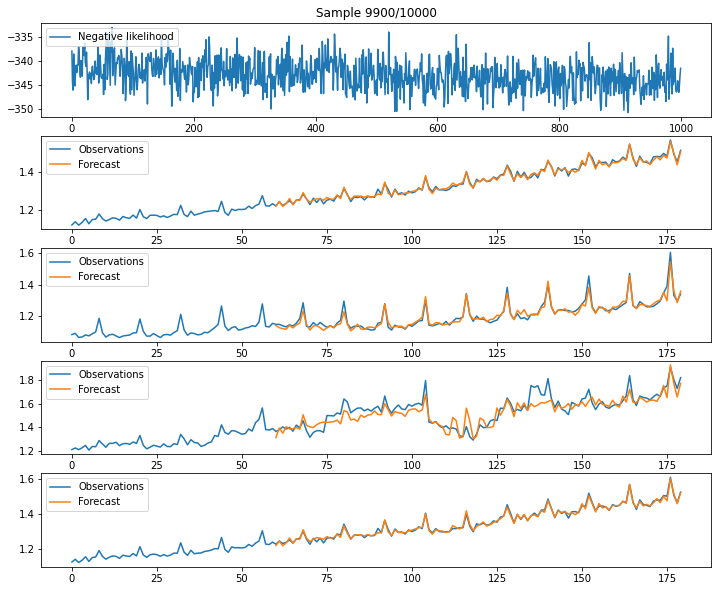

In [397]:
opt = Adam(model.parameters(), lr=0.0005)

model.train()
n_samples = 10000
batch_size = 128
for s in range(n_samples):
    idx = np.random.choice(np.arange(train_torch.shape[0]), size=batch_size)
    train_batch = train_torch[idx]

    x, y = train_batch[:, 0:120], train_batch[:, 60:180]

    mu, sigma = model(x)
    train_loss = gaussian_loss(mu, sigma, y)

    opt.zero_grad()
    train_loss.backward()
    opt.step()

    logs.append(train_loss.item())
    if s % 100 == 0:
        plt.figure(figsize=(12, 2*5))
        plt.subplot(5, 1, 1)
        plt.plot(logs[-1000:], label='Negative likelihood')
        plt.legend(loc='upper left')
        plt.title('Sample {}/{}'.format(s, n_samples))
        obs = train_batch[0].cpu().numpy()
        forecast = mu[0].detach().cpu().numpy()
        for i in range(4):
            plt.subplot(5, 1, i+2)
            plt.plot(np.arange(180), obs[:, i], label='Observations')
            plt.plot(np.arange(60, 180), forecast[:, i], label='Forecast')
            plt.legend(loc='upper left')
        plt.show()
        clear_output(wait=True)

In [398]:
print('Train loss: {:.2f}'.format(logs[-1]))

Train loss: -348.14


In [399]:
#torch.save(model, 'gaussian_tcn_shallow_glance.model')
#model = torch.load('gaussian_tcn_shallow_glance.model')

In [403]:
model.eval()
with torch.no_grad():
    mu, sigma = model(train_torch[-1:, -120:])
point_forecast = mu[0].cpu().numpy()[-60:]
lower_forecast = (mu[0] - sigma[0] * 2.807034).cpu().numpy()[-60:]
upper_forecast = (mu[0] + sigma[0] * 2.807034).cpu().numpy()[-60:]
point_forecast = scaler.inverse_transform(point_forecast)
lower_forecast = scaler.inverse_transform(lower_forecast)
upper_forecast = scaler.inverse_transform(upper_forecast)
values = scaler.inverse_transform(train.values)
for i, col in enumerate(train.columns):
    train[col] = values[:, i]

In [404]:
pred = pd.DataFrame(
    point_forecast, columns=test.columns, index=test.index)
lower = pd.DataFrame(
    lower_forecast, columns=test.columns, index=test.index)
upper = pd.DataFrame(
    upper_forecast, columns=test.columns, index=test.index)

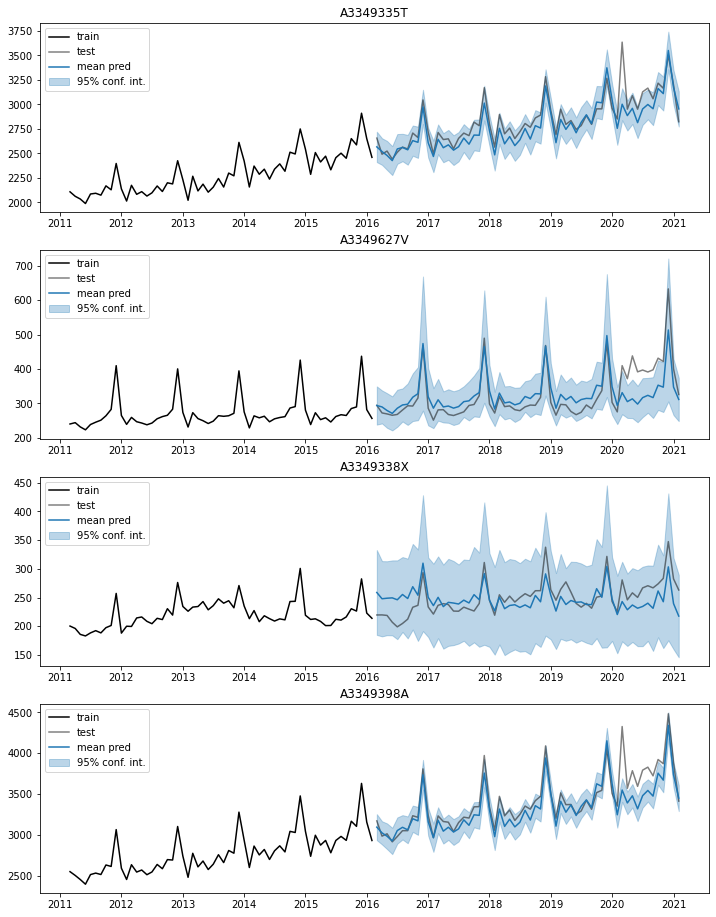

In [405]:
plt.figure(figsize=(12, 4*4))
for i, col in enumerate(train.columns):
    plt.subplot(4, 1, i+1)
    plt.plot(train[col].iloc[-60:], c='black', label='train')
    plt.plot(test[col], c='black', label='test', alpha=0.5)
    plt.plot(pred[col], c='tab:blue', label='mean pred')
    plt.fill_between(test.index, lower[col], upper[col], 
                     color='tab:blue', alpha=0.3, label='95% conf. int.')
    plt.legend(loc='upper left')
    plt.title(col)

In [406]:
def quantile_loss(y_pred, target, quantiles=[0.025, 0.5, 0.975]):
    losses = []
    for i, q in enumerate(quantiles):
        error = target - y_pred[..., i]
        loss = np.max([(q - 1) * error, q * error], axis=0)
        losses.append(loss)
    losses = np.array(losses)
    return 2 * losses.sum() / np.abs(target + 1e-4).sum()

In [407]:
y_pred = np.stack([lower.values, pred.values, upper.values], axis=2)
print('Quantile loss: {:.4f}'.format(quantile_loss(y_pred, test.values)))

Quantile loss: 0.0533


### Stationary

In [366]:
train_bound = pd.Timestamp('2016-02-01')
train = aus_retail[aus_retail.index <= train_bound].iloc[:, :4]
test = aus_retail[aus_retail.index > train_bound].iloc[:, :4]
train.shape, test.shape

((407, 4), (60, 4))

In [367]:
boxcox_model = BoxCox()
lambds = {}
bc_train = train.copy()
for col in train.columns:
    bc_train[col], lambds[col] = boxcox_model.transform_boxcox(
        train[col].values, method='loglik')
lambds

{'A3349335T': 0.2849374963384148,
 'A3349338X': 0.85262045917212,
 'A3349398A': 0.3239342116951898,
 'A3349627V': -0.10305050735646222}

In [368]:
for col in train.columns:
    kpss_stat, p_value, lags, crit = kpss(bc_train[col], nlags='auto')
    print(col, 'Stationary' if p_value > 0.05 else 'Non-stationary')

A3349335T Non-stationary
A3349627V Non-stationary
A3349338X Non-stationary
A3349398A Non-stationary


In [369]:
def differencing(ts, periods):
    return ts.diff(periods=periods).dropna()

def integration(ts, periods, original_ts):
    ts_concat = pd.concat([original_ts.iloc[:periods], ts])
    ts_integration = []
    for i in range(periods):
        ts_integration.append(ts_concat.iloc[i::periods].cumsum(axis=0))
    return pd.concat(ts_integration).sort_index()

In [370]:
seasonal_lag = 12
t_train = differencing(bc_train, seasonal_lag)

In [371]:
for col in train.columns:
    kpss_stat, p_value, lags, crit = kpss(t_train[col], nlags='auto')
    print(col, 'Stationary' if p_value > 0.05 else 'Non-stationary')

A3349335T Stationary
A3349627V Stationary
A3349338X Stationary
A3349398A Stationary


In [372]:
train_torch = []
for i in range(t_train.shape[0] - 180 + 1):
    train_torch.append(t_train.iloc[i:i+180].values)
train_torch = torch.Tensor(train_torch).to('cuda')
train_torch.shape

torch.Size([216, 180, 4])

In [373]:
model = DeepTCN()
model.to('cuda');

In [374]:
logs = []

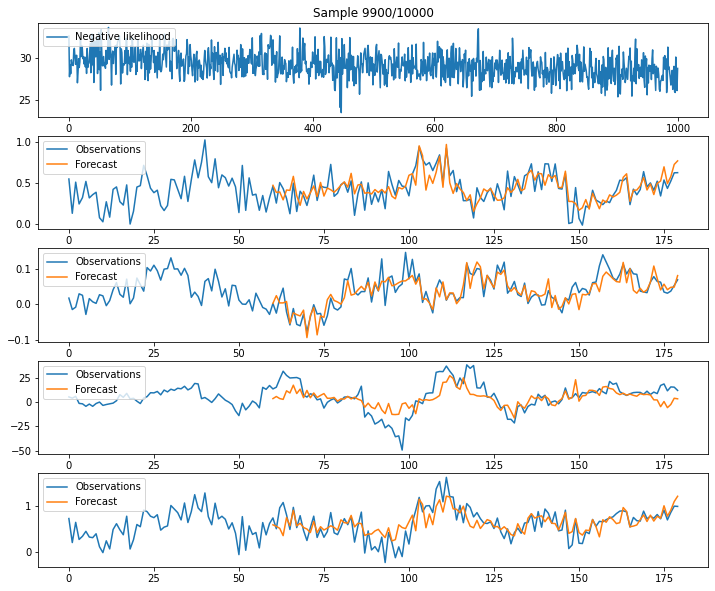

In [376]:
opt = Adam(model.parameters(), lr=0.0005)

model.train()
n_samples = 20000
batch_size = 128
for s in range(n_samples):
    idx = np.random.choice(np.arange(train_torch.shape[0]), size=batch_size)
    train_batch = train_torch[idx]

    x, y = train_batch[:, 0:120], train_batch[:, 60:180]

    mu, sigma = model(x)
    train_loss = gaussian_loss(mu, sigma, y)

    opt.zero_grad()
    train_loss.backward()
    opt.step()

    logs.append(train_loss.item())
    if s % 100 == 0:
        plt.figure(figsize=(12, 2*5))
        plt.subplot(5, 1, 1)
        plt.plot(logs[-1000:], label='Negative likelihood')
        plt.legend(loc='upper left')
        plt.title('Sample {}/{}'.format(s, n_samples))
        obs = train_batch[0].cpu().numpy()
        forecast = mu[0].detach().cpu().numpy()
        for i in range(4):
            plt.subplot(5, 1, i+2)
            plt.plot(np.arange(180), obs[:, i], label='Observations')
            plt.plot(np.arange(60, 180), forecast[:, i], label='Forecast')
            plt.legend(loc='upper left')
        plt.show()
        clear_output(wait=True)

In [377]:
print('Train loss: {:.2f}'.format(logs[-1]))

Train loss: 26.28


In [378]:
model.eval()
with torch.no_grad():
    mu, sigma = model(train_torch[-1:, -120:])
point_forecast = mu[0].cpu().numpy()[-60:]
lower_forecast = (mu[0] - sigma[0] * 2.807034).cpu().numpy()[-60:]
upper_forecast = (mu[0] + sigma[0] * 2.807034).cpu().numpy()[-60:]

point_forecast = pd.DataFrame(
    point_forecast, columns=test.columns, index=test.index)
lower_forecast = pd.DataFrame(
    lower_forecast, columns=test.columns, index=test.index)
upper_forecast = pd.DataFrame(
    upper_forecast, columns=test.columns, index=test.index)

pred = point_forecast.copy()
lower = lower_forecast.copy()
upper = upper_forecast.copy()

bc_pred = integration(point_forecast, seasonal_lag, bc_train.iloc[-seasonal_lag:]).iloc[-60:]
bc_lower = integration(lower_forecast, seasonal_lag, bc_train.iloc[-seasonal_lag:]).iloc[-60:]
bc_upper = integration(upper_forecast, seasonal_lag, bc_train.iloc[-seasonal_lag:]).iloc[-60:]
bc_pred.shape

(60, 4)

In [379]:
bc_lower[bc_lower < 0] = 0

In [380]:
pred = bc_pred.copy()
lower = bc_lower.copy()
upper = bc_upper.copy()
for col in bc_pred.columns:
    pred[col] = inv_boxcox(bc_pred[col].values, lambds[col])
    lower[col] = inv_boxcox(bc_lower[col].values, lambds[col])
    upper[col] = inv_boxcox(bc_upper[col].values, lambds[col])
pred.head()

,A3349335T,A3349627V,A3349338X,A3349398A
Series ID,,,,
2016-03-01,2594.153679,310.038981,233.693983,3119.187997
2016-04-01,2511.023285,287.959727,228.893677,3009.581822
2016-05-01,2550.137917,289.789465,220.803164,3038.106776
2016-06-01,2411.974756,273.003506,217.438892,2885.257095
2016-07-01,2531.528491,288.066047,226.823631,3031.222358


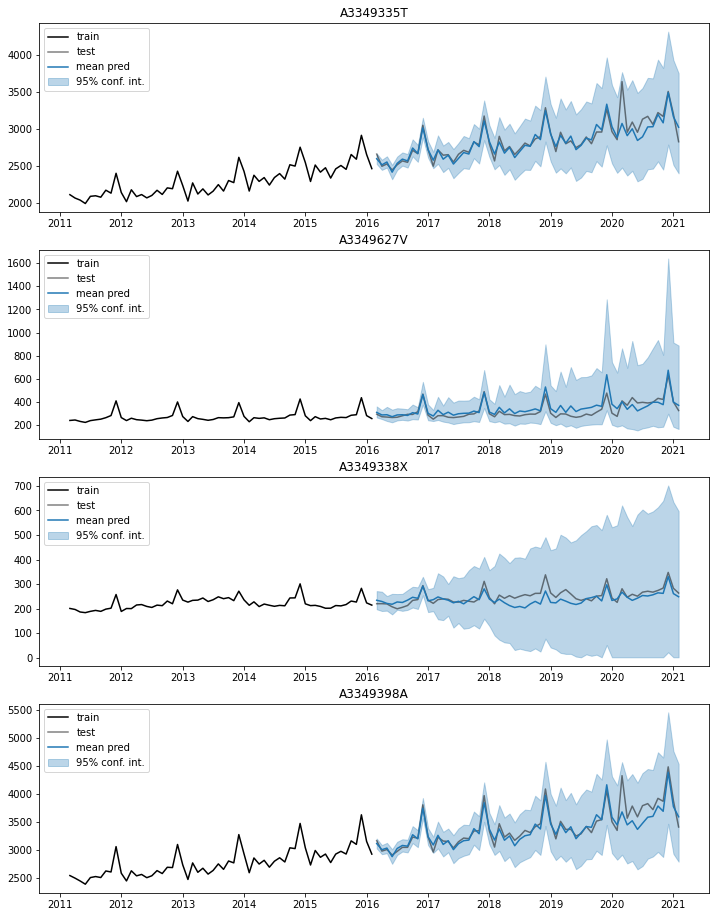

In [381]:
plt.figure(figsize=(12, 4*4))
for i, col in enumerate(train.columns):
    plt.subplot(4, 1, i+1)
    plt.plot(train[col].iloc[-60:], c='black', label='train')
    plt.plot(test[col], c='black', label='test', alpha=0.5)
    plt.plot(pred[col], c='tab:blue', label='mean pred')
    plt.fill_between(pred.index, lower[col], upper[col], 
                     color='tab:blue', alpha=0.3, label='95% conf. int.')
    plt.legend(loc='upper left')
    plt.title(col)

In [382]:
y_pred = np.stack([lower.values, pred.values, upper.values], axis=2)
print('Quantile loss: {:.4f}'.format(quantile_loss(y_pred, test.values)))

Quantile loss: 0.0459
